## Setup

In [18]:
!pip install torchsummary

In [19]:
import time
import os
import io
import requests

import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageNet
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

from PIL import Image
import matplotlib.pylab as plt
import cv2

# Integrated Gradient on Classification Models

## First Model : Resnet18

## Download a pretrained image classifier

In [20]:
model = models.resnet18(pretrained=True)
model.eval()
summary(model.cuda(), (3, 224, 224))
model.cpu()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
import urllib

def load_imagenet_labels(file_path):
    # download the labels file
    labels_file = urllib.request.urlretrieve(file_path, 'ImageNetLabels.txt')[0]
    with open(labels_file, 'r') as reader:
        labels = reader.read().splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

## Load and preprocess images

In [22]:
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
#    transforms.Normalize(
#        mean=[0.485, 0.456, 0.406],
#        std=[0.229, 0.224, 0.225]
#    )
])

def read_image(file_name):
    resp = requests.get(file_name)
    image = Image.open(io.BytesIO(resp.content))
    image = preprocess(image).unsqueeze(0)
    print(image.shape)
    return image

In [23]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Viaduct': 'https://images.pexels.com/photos/14850976/pexels-photo-14850976.jpeg?cs=srgb&dl=pexels-captain-teflon-14850976.jpg&fm=jpg',
    'Starfish': 'https://images.pexels.com/photos/7293094/pexels-photo-7293094.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1',
    'Cabbage Butterlfy': 'https://images.pexels.com/photos/11585550/pexels-photo-11585550.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1',
    'Reflex Camera': 'https://images.pexels.com/photos/14232471/pexels-photo-14232471.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'
}

img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_url.items()}

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


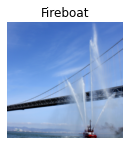

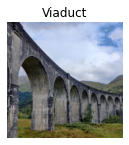

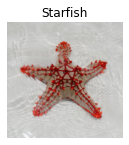

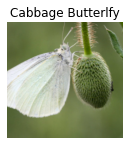

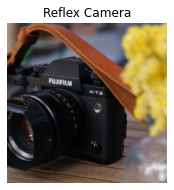

In [24]:
for n, (name, img_tensor) in enumerate(img_name_tensors.items()):
    plt.figure(figsize=(12, 12))
    img_tensor_plot = img_tensor.squeeze(0).permute(1, 2, 0)
    ax = plt.subplot(1, len(img_name_tensors.keys()), n+1)
    ax.imshow(img_tensor_plot)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()

## Classify images

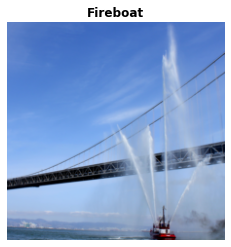

fireboat: 99.4%


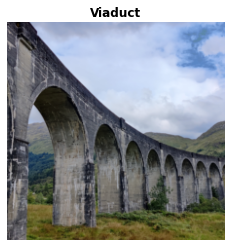

viaduct: 100.0%


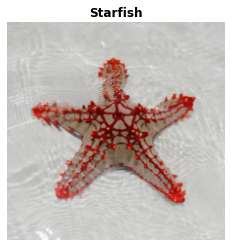

starfish: 99.5%


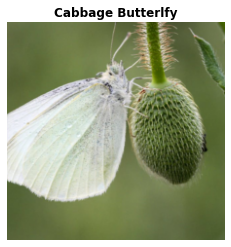

cabbage butterfly: 80.8%


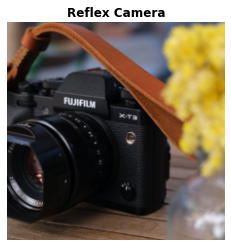

reflex camera: 11.5%


In [25]:
for (name, img_tensor) in img_name_tensors.items():
    output = model(img_tensor)

    _, pred = output.max(1)
    probs = torch.nn.functional.softmax(output, dim=1)
    pred_score = probs[0][pred].item()

    class_label = imagenet_labels[pred+1]
    
    img_tensor_plot = img_tensor.squeeze(0).permute(1, 2, 0)
    plt.imshow(img_tensor_plot)
    plt.title(name, fontweight='bold')
    plt.axis('off')
    plt.show()
    print(f'{class_label}: {pred_score:0.1%}')

## Calculate Integrated Gradients

### Create the baseline:

A baseline serves as a reference point for determining the significance of each pixel in the input image. It measures the effect of the absence of a pixel on the prediction of "Starfish" compared to its effect when present in the image. The selection of the baseline is crucial for understanding and visualizing the pixel feature importance. In this case, a black image with all zero pixel values is used as the baseline.

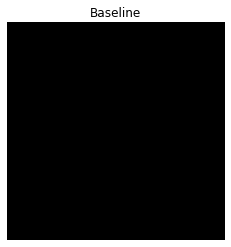

In [26]:
baseline = torch.zeros(size=(224,224,3))

plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### Interpolate images

Initially, we need to create a linear interpolation between the baseline image and the original image. The interpolated images can be considered as small increments in the feature space between the baseline and the input image, represented by in the original equation.

In [27]:
m_steps = 50
alphas = torch.linspace(start=0.0, end=1.0, steps=m_steps+1)

def interpolate_images(baseline, image, alphas):
    alphas_x = alphas.view(-1, 1, 1, 1)
    baseline_x = baseline.unsqueeze(0)
    input_x = image.permute(0,2,3,1)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    return images

interpolated_images = interpolate_images(baseline=baseline, image=img_name_tensors['Starfish'], alphas=alphas)

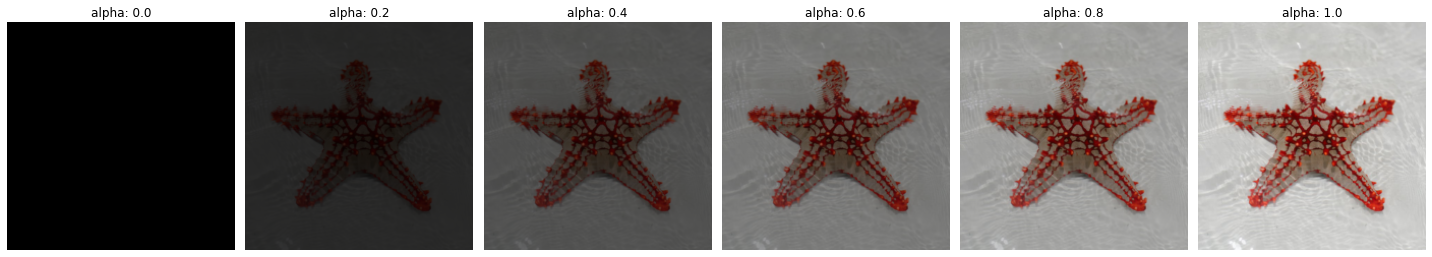

In [28]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout();

## Compute Gradients

In [29]:
def compute_gradients(images, target_class_idx):
    images = images.requires_grad_()
    logits = model(images.permute(0,3,1,2))
    print(logits)
    
    probs = F.softmax(logits[:, target_class_idx], dim=-1)
    probs.sum().backward(retain_graph=True)
    
    gradients = images.grad
    
    return gradients

path_gradients = compute_gradients(images=interpolated_images, target_class_idx=327)
print(path_gradients.shape)

tensor([[-0.0694,  0.6170, -1.9313,  ..., -1.3689, -0.0150,  0.3448],
        [-0.2799,  0.4466, -1.7650,  ..., -1.4005, -0.0990,  0.5470],
        [-0.5715,  0.3520, -1.5682,  ..., -1.3762, -0.0772,  0.8783],
        ...,
        [ 0.5905,  6.9565,  1.0536,  ..., -2.5342,  0.4491,  1.8848],
        [ 0.5743,  6.9245,  1.0116,  ..., -2.5308,  0.4296,  1.8642],
        [ 0.5612,  6.8920,  0.9740,  ..., -2.5248,  0.4128,  1.8414]],
       grad_fn=<AddmmBackward0>)
torch.Size([51, 224, 224, 3])


### Visualizing gradient saturation

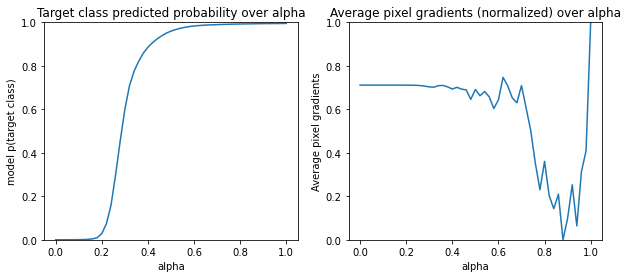

In [30]:
pred = model(interpolated_images.permute(0,3,1,2))
pred_proba = torch.nn.functional.softmax(pred, dim=-1)[:, 327].detach().numpy()

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = torch.mean(path_gradients, dim=(1, 2, 3))
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads - torch.min(average_grads)) / (torch.max(average_grads) - torch.min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

### Integral approximation

In [31]:
def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / 2.0
    integrated_gradients = torch.mean(grads, dim=0)
    return integrated_gradients

ig = integral_approximation(gradients=path_gradients)
print(ig.shape)

torch.Size([224, 224, 3])


## ALL in one

In [32]:
def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=32):
    alphas = torch.linspace(start=0.0, end=1.0, steps=m_steps+1)

    gradient_batches = []

    for alpha in torch.arange(0, len(alphas), batch_size):
        from_ = alpha
        to = min(from_ + batch_size, len(alphas))
        alpha_batch = alphas[int(from_): int(to)]

        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)

    total_gradients = torch.cat(gradient_batches, dim=0)
    
    avg_gradients = integral_approximation(gradients=total_gradients)

    integrated_gradients = (image.squeeze(0).permute(1,2,0) - baseline)
    integrated_gradients *= avg_gradients

    return integrated_gradients

def one_batch(baseline, image, alpha_batch, target_class_idx):
    interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)
    gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    return gradient_batch

ig_attributions = integrated_gradients(baseline=baseline, image=img_name_tensors['Starfish'], target_class_idx=327, m_steps=240)
print(ig_attributions.shape)

tensor([[-0.0694,  0.6170, -1.9313,  ..., -1.3689, -0.0150,  0.3448],
        [-0.0860,  0.6078, -1.9251,  ..., -1.3696, -0.0237,  0.3616],
        [-0.1300,  0.5728, -1.9004,  ..., -1.3784, -0.0445,  0.4100],
        ...,
        [-0.5201,  1.4214,  0.6713,  ..., -1.6740, -0.5454,  2.5184],
        [-0.5019,  1.5256,  0.7444,  ..., -1.7067, -0.5753,  2.5528],
        [-0.4734,  1.6369,  0.8249,  ..., -1.7591, -0.6052,  2.5702]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.4355,  1.7469,  0.9067,  ..., -1.8226, -0.6380,  2.5885],
        [-0.3704,  1.8701,  1.0123,  ..., -1.8944, -0.6717,  2.5787],
        [-0.2876,  1.9902,  1.1169,  ..., -1.9653, -0.6768,  2.5427],
        ...,
        [ 0.7322,  3.6641,  2.5663,  ..., -2.8688,  0.1490,  1.6482],
        [ 0.7147,  3.7076,  2.5808,  ..., -2.8720,  0.1700,  1.6414],
        [ 0.7011,  3.7563,  2.5946,  ..., -2.8712,  0.1916,  1.6373]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.6893,  3.8016,  2.6076,  ..., -2.8694,  0.2143,  1.628

## Visualize attributions

tensor([[-0.0694,  0.6170, -1.9313,  ..., -1.3689, -0.0150,  0.3448],
        [-0.0860,  0.6078, -1.9251,  ..., -1.3696, -0.0237,  0.3616],
        [-0.1300,  0.5728, -1.9004,  ..., -1.3784, -0.0445,  0.4100],
        ...,
        [-0.5201,  1.4214,  0.6713,  ..., -1.6740, -0.5454,  2.5184],
        [-0.5019,  1.5256,  0.7444,  ..., -1.7067, -0.5753,  2.5528],
        [-0.4734,  1.6369,  0.8249,  ..., -1.7591, -0.6052,  2.5702]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.4355,  1.7469,  0.9067,  ..., -1.8226, -0.6380,  2.5885],
        [-0.3704,  1.8701,  1.0123,  ..., -1.8944, -0.6717,  2.5787],
        [-0.2876,  1.9902,  1.1169,  ..., -1.9653, -0.6768,  2.5427],
        ...,
        [ 0.7322,  3.6641,  2.5663,  ..., -2.8688,  0.1490,  1.6482],
        [ 0.7147,  3.7076,  2.5808,  ..., -2.8720,  0.1700,  1.6414],
        [ 0.7011,  3.7563,  2.5946,  ..., -2.8712,  0.1916,  1.6373]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.6893,  3.8016,  2.6076,  ..., -2.8694,  0.2143,  1.628

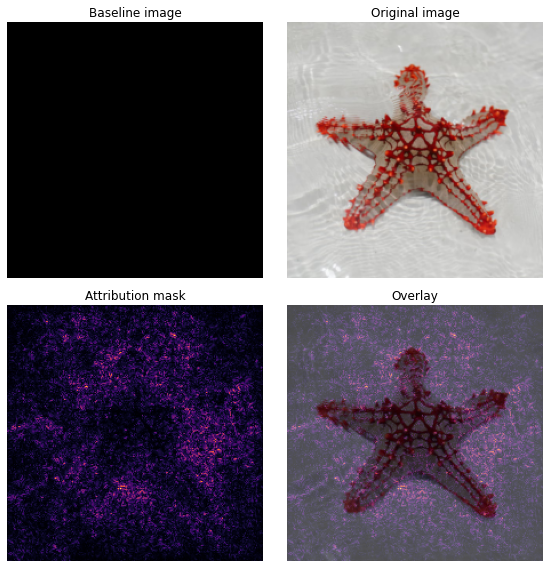

In [33]:
def plot_img_attributions(baseline,image,target_class_idx,m_steps=50,cmap=None,overlay_alpha=0.4):
    attributions = integrated_gradients(baseline=baseline,image=image,target_class_idx=target_class_idx,m_steps=m_steps)
    attribution_mask = torch.sum(torch.abs(attributions), dim=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image.squeeze(0).permute(1,2,0))
    axs[0, 1].axis('off')

    print(attribution_mask.shape)
    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image.squeeze(0).permute(1,2,0), alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

_ = plot_img_attributions(image=img_name_tensors['Starfish'], baseline=baseline, target_class_idx=327, m_steps=240, cmap=plt.cm.inferno, overlay_alpha=0.4)

tensor([[-0.0694,  0.6170, -1.9313,  ..., -1.3689, -0.0150,  0.3448],
        [-0.0829,  0.6077, -1.9319,  ..., -1.3712, -0.0229,  0.3488],
        [-0.1089,  0.5865, -1.9316,  ..., -1.3754, -0.0381,  0.3604],
        ...,
        [-0.1137,  0.8261, -1.0809,  ..., -1.4464,  0.5939,  1.6737],
        [-0.1267,  0.8376, -0.9991,  ..., -1.4467,  0.5981,  1.7250],
        [-0.1412,  0.8380, -0.9100,  ..., -1.4500,  0.5830,  1.7730]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.1688,  0.8302, -0.8312,  ..., -1.4583,  0.5666,  1.8134],
        [-0.2000,  0.8199, -0.7489,  ..., -1.4763,  0.5504,  1.8503],
        [-0.2272,  0.8063, -0.6686,  ..., -1.4947,  0.5354,  1.8761],
        ...,
        [-0.7015,  0.3127,  0.3188,  ..., -2.0232,  0.8303,  1.8269],
        [-0.7102,  0.2989,  0.3302,  ..., -2.0402,  0.8403,  1.8294],
        [-0.7130,  0.2837,  0.3411,  ..., -2.0537,  0.8512,  1.8315]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.7128,  0.2692,  0.3512,  ..., -2.0625,  0.8621,  1.832

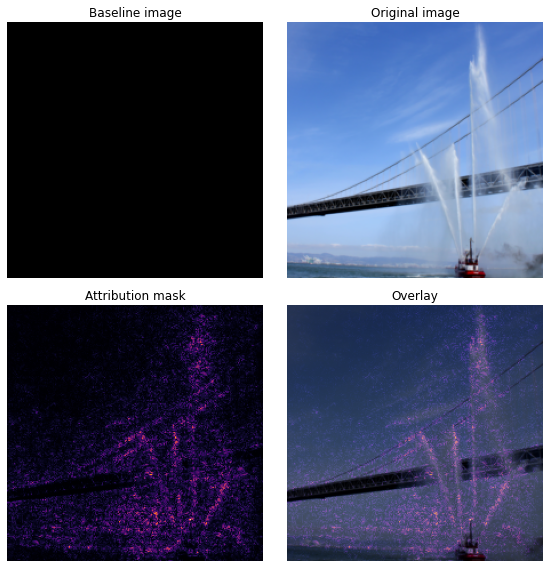

In [34]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'], baseline=baseline, target_class_idx=555, m_steps=240, cmap=plt.cm.inferno, overlay_alpha=0.4)